In [86]:
import cv2
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image


# CODE WITHOUT ANY AI OR CLASSIFIER TRAINING

Step: Original Image


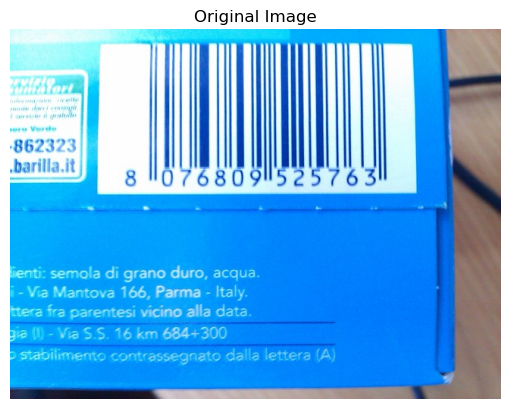

Step: Grayscale


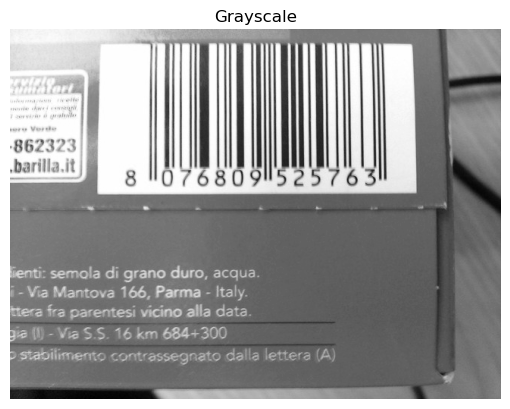

Step: Gradient


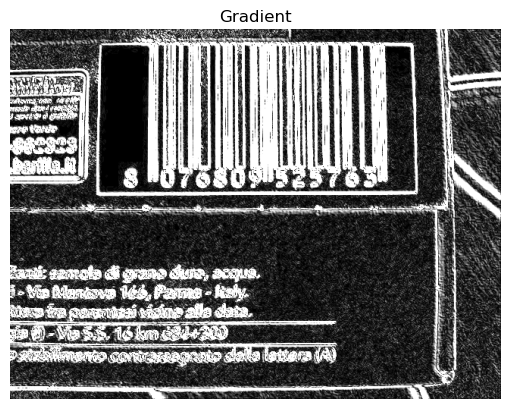

Step: Threshold


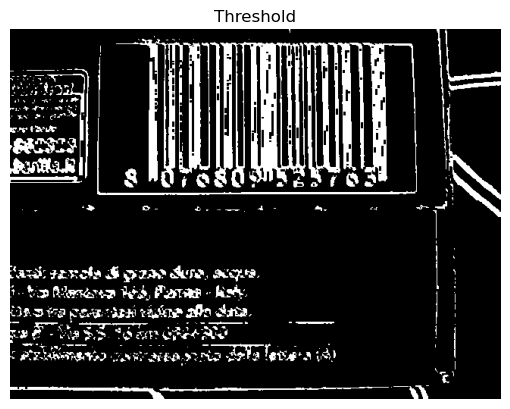

Step: Morphological Transformations


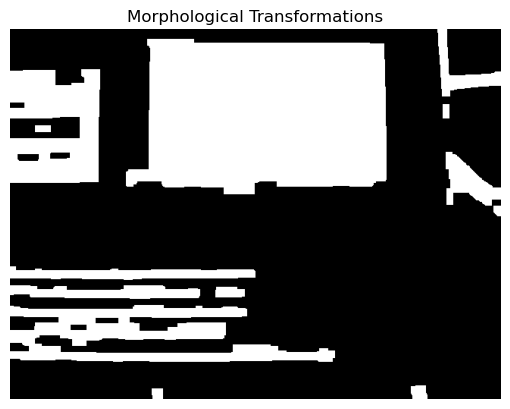

Step: Bounding Box


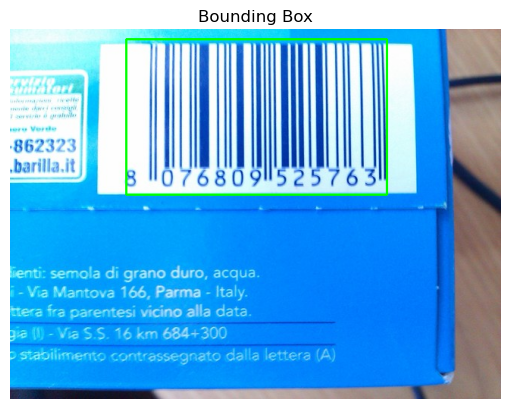

Euclidean Match Found: dataset/train/barcode/IMAG0510.jpg


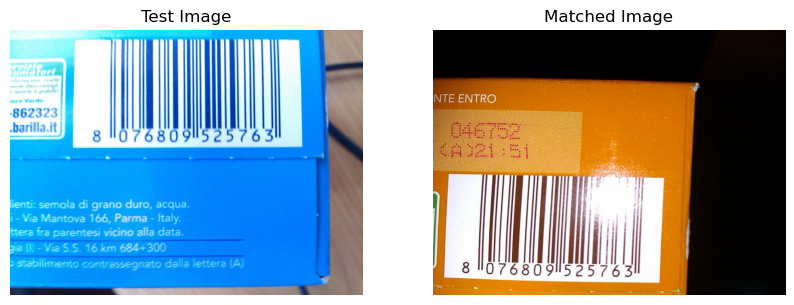

Error: Could not read image at dataset/train/barcode/.DS_Store


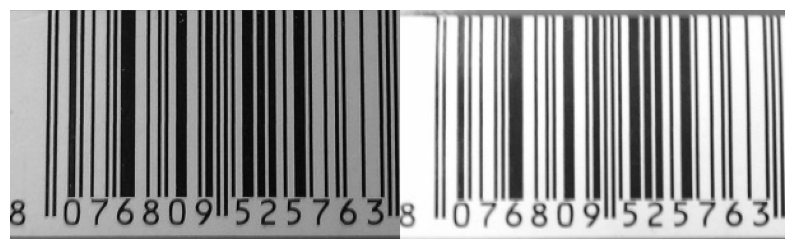

Best match found with 74 good matches.
Best match path: dataset/train/barcode/IMAG0519.jpg


In [96]:
def display_side_by_side(test_image_path, matched_image_path, matched_title):
    test_image = cv2.imread(test_image_path)
    matched_image = cv2.imread(matched_image_path)

    # Convert BGR to RGB for Matplotlib
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    matched_image = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(matched_image)
    plt.title(matched_title)
    plt.axis("off")

    plt.show()

def log_and_display(title, image):
    print(f"Step: {title}")
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if len(image.shape) == 3 else image, cmap='gray')
    plt.axis('off')
    plt.show()

# Extract features for Euclidean comparison
def extract_features(image_path, is_test_image=False):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    if is_test_image:
        log_and_display("Original Image", image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if is_test_image:
        log_and_display("Grayscale", gray)

    gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    if is_test_image:
        log_and_display("Gradient", gradient)
    blurred = cv2.blur(gradient, (3, 3))

    _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    if is_test_image:
        log_and_display("Threshold", thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    if is_test_image:
        log_and_display("Morphological Transformations", closed)

    cnts, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return None

    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    if is_test_image:
        #the bounding rectangle on the image
        result_image = image.copy()
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        log_and_display("Bounding Box", result_image)

    aspect_ratio = float(w) / h
    extent = cv2.contourArea(c) / (w * h)
    solidity = cv2.contourArea(c) / cv2.contourArea(cv2.convexHull(c))

    return [w, h, aspect_ratio, extent, solidity, x, y, w, h]

# Euclidean Distance Matching
def prepare_dataset(dataset_dir):
    dataset_features = []
    image_paths = []
    for filename in os.listdir(dataset_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(dataset_dir, filename)
            features = extract_features(image_path)
            if features is not None:
                dataset_features.append(features)
                image_paths.append(image_path)
    return dataset_features, image_paths

def compare_with_dataset_Euclidean(test_image_path, training_dataset_dir, threshold=50):
    test_image = Image.open(test_image_path)
    test_features = extract_features(test_image_path, is_test_image=True)
    if test_features is None:
        print("Error: Unable to extract features from the test image.")
        return False

    test_vector = np.array(test_features[:-4])
    dataset_features, image_paths = prepare_dataset(training_dataset_dir)

    for i, features in enumerate(dataset_features):
        training_vector = np.array(features[:-4])
        distance = np.linalg.norm(test_vector - training_vector)

        if distance < threshold:
            print(f"Euclidean Match Found: {image_paths[i]}")

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(test_image)
            plt.title("Test Image")
            plt.axis("off")
            matched_image = cv2.imread(image_paths[i])
            plt.subplot(1, 2, 2)
            plt.imshow(matched_image)
            plt.title(f"Matched Image")
            plt.axis("off")
            plt.show()
            return True

    print("No match found using Euclidean Distance.")
    return False

# SIFT Matching
def extract_barcode_region(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    blurred = cv2.blur(gradient, (3, 3))
    _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)

    cnts, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    barcode_region = gray[y:y + h, x:x + w]

    return barcode_region
def compare_barcodes_with_sift(ref_image_path, test_image_path, match_threshold=20):
    ref_barcode = extract_barcode_region(ref_image_path)
    test_barcode = extract_barcode_region(test_image_path)

    if ref_barcode is None or test_barcode is None:
        return 0, None

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    ref_keypoints, ref_descriptors = sift.detectAndCompute(ref_barcode, None)
    test_keypoints, test_descriptors = sift.detectAndCompute(test_barcode, None)

    if ref_descriptors is None or test_descriptors is None:
        return 0, None

    # Match features using BFMatcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(ref_descriptors, test_descriptors, k=2)

    # Apply Lowe's ratio test to retain good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    return len(good_matches), (ref_barcode, test_barcode)

def display_match_result(ref_image, test_image, match_found):
    if match_found:
        # Ensure both images have the same height
        ref_height, ref_width = ref_image.shape[:2]
        test_height, test_width = test_image.shape[:2]

        # Resize test_image to match the height of ref_image
        if ref_height != test_height:
            if ref_height < test_height:
                # Resize test_image
                test_image = cv2.resize(test_image, (int(test_width * ref_height / test_height), ref_height))
            else:
                # Resize ref_image
                ref_image = cv2.resize(ref_image, (int(ref_width * test_height / ref_height), test_height))

        # Stack images horizontally
        combined_image = np.hstack((ref_image, test_image))

        # Display the combined image
        plt.figure(figsize=(10, 5))
        plt.imshow(combined_image, cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        print("No match found using SIFT.")

def find_best_match(dataset_dir, test_image_path, match_threshold=70): #50
    best_match_score = 0
    best_match_images = None

    best_match_path = None

    for root, _, files in os.walk(dataset_dir):
        for file in files:
            ref_image_path = os.path.join(root, file)
            match_score, match_images = compare_barcodes_with_sift(ref_image_path, test_image_path, match_threshold)
            if match_score > best_match_score:
                best_match_score = match_score
                best_match_images = match_images
                best_match_path = ref_image_path


    if best_match_score > match_threshold and best_match_images:
        ref_image, test_image = best_match_images
        display_match_result(ref_image, test_image, True)
        print(f"Best match found with {best_match_score} good matches.")
        print(f"Best match path: {best_match_path}")
    else:
        display_match_result(None, None, False)



# Paths
training_dataset_dir = "dataset/train/barcode"

test_image_path = "/Users/mohammedwalidadawy/Downloads/barcode-scanning-challenges-printing.jpg"
test_image_path = "dataset/test/barcode/doesnt_exist4.jpg"
test_image_path = "dataset/test/barcode/IMAG0512.jpg"


# Run both matching methods
compare_with_dataset_Euclidean(test_image_path, training_dataset_dir)
find_best_match(training_dataset_dir, test_image_path)


# RANDOM FOREST CLASSIFIER

Model Accuracy: 0.94


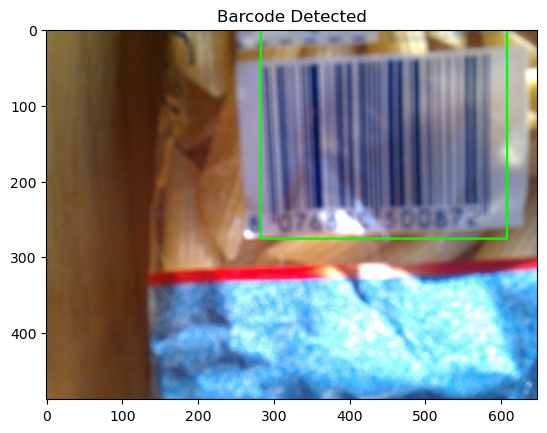

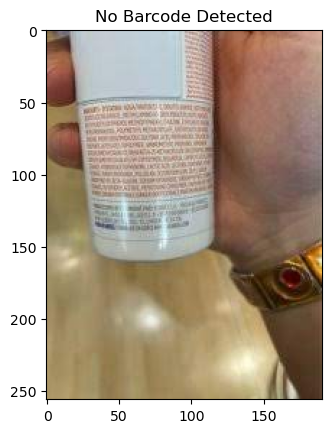

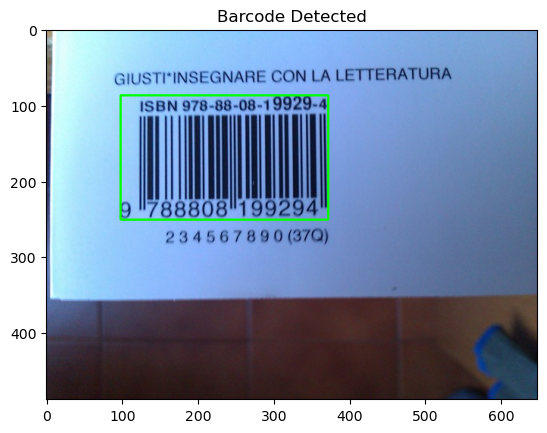

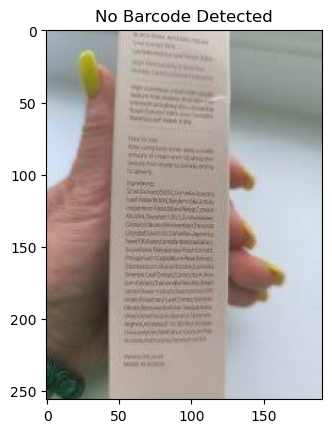

In [97]:
def prepare_dataset(image_directory, label):
    data = []
    labels = []
    if not os.path.exists(image_directory):
        print(f"Error: Directory {image_directory} does not exist.")
        return data, labels  # Return empty lists if directory doesn't exist

    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_directory, filename)
            features = extract_features(image_path)
            if features is not None:
                data.append(features[:-4])  # Exclude the bounding box coordinates from features
                labels.append(label)
    return data, labels

# Training data directories
barcode_dir = "/Users/mohammedwalidadawy/PycharmProjects/ProjectDemo/dataset/train/barcode"
non_barcode_dir = "/Users/mohammedwalidadawy/PycharmProjects/ProjectDemo/dataset/train/no_barcode"

# Load and prepare the dataset
barcode_data, barcode_labels = prepare_dataset(barcode_dir, 1)  # Label 1 for barcodes
non_barcode_data, non_barcode_labels = prepare_dataset(non_barcode_dir, 0)  # Label 0 for non-barcodes

# Ensure data is not empty
if not barcode_data or not non_barcode_data:
    print("Error: Insufficient data for training. Check image directories.")
    exit()

# Combine barcode and non-barcode data
data = np.array(barcode_data + non_barcode_data)
labels = np.array(barcode_labels + non_barcode_labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Test the model with a new image
def test_image(image_path):
    if not os.path.exists(image_path):
        print(f"Error: Test image {image_path} does not exist.")
        return

    features = extract_features(image_path)
    if features is None:
        print("No barcode detected.")
        return

    prediction = model.predict([features[:-4]])[0]  # Use only the features, not the bounding box

    image = cv2.imread(image_path)

    if prediction == 1:
        # If a barcode is detected, extract and crop the barcode region
        x, y, w, h = features[-4:]  # Get the bounding box coordinates
        cropped_image = image[y:y+h, x:x+w]  # Crop the image using the bounding box coordinates

        # # Display the cropped image
        # plt.title("Barcode Detected - Cropped")
        # plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        # plt.show()
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.title("Barcode Detected")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

    else:
        plt.title("No Barcode Detected")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

test_image_path = "dataset/test/barcode/IMAG0435.jpg"
test_image(test_image_path)

test_image_path = "dataset/test/no_barcode/images-3.jpeg"
test_image(test_image_path)

test_image_path = "dataset/test/barcode/IMAG0554.jpg"
test_image(test_image_path)

test_image_path = "dataset/test/no_barcode/images-7.jpeg"
test_image(test_image_path)
